# ResNet50 Neural Network Analysis

## Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
import os
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
CLASSES = ['Paul_Gauguin',
 'Edgar_Degas',
 'Vincent_van_Gogh',
 'Albrecht_Dürer',
 'Pablo_Picasso',
 'Titian',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Rembrandt']

TRAIN_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train'
TEST_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/test'
VAL_DIR = '/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/val'

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 47

MODEL_DIR = "/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights"

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

LOCAL_PATH = "/content/model"

if not os.path.exists(LOCAL_PATH):
    os.makedirs(LOCAL_PATH)

## Compute class weights

In [ ]:
GENERAL_PATH="/content/drive/Shareddrives/DeepLearning-ArtClassification/Data/Split-dataset/train"

class_cardinality={}
for it in os.scandir(GENERAL_PATH):
    if it.is_dir():
      class_cardinality[it.name]=len(os.listdir(it.path))

df = pd.DataFrame(class_cardinality.items(), columns=['Name', 'Num_Paintings'])
df["Class_Weight"] = df.Num_Paintings.sum() / (len(CLASSES)*df.Num_Paintings)
CLASS_WEIGHTS = df['Class_Weight'].to_dict()
CLASS_WEIGHTS

{0: 1.258483452031839,
 1: 0.556193297537493,
 2: 0.44549903603737206,
 3: 1.1925367209210005,
 4: 0.889546935149541,
 5: 1.5342185903983656,
 6: 1.3452754142409316,
 7: 1.6352749047359825,
 8: 1.1620889748549323,
 9: 1.508789552988448,
 10: 1.4923000496770988}

## Utility funciton to reuse snippet of code

In [ ]:
def model_compiler(model, learning_rate = 0.001, my_loss = "sparse_categorical_crossentropy", my_optimizer = "Adam", my_metrics = "accuracy"):
  
  custom_opt = optimizers.Adam(learning_rate=learning_rate)
  
  model.compile(loss = my_loss, optimizer = custom_opt, metrics = [my_metrics])
  return model

def model_executor(model, model_name, train, validation, epoch_number = 20, patience = 2, class_weights = None):
  model_path = LOCAL_PATH + "/" + model_name + ".h5"
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience),
      keras.callbacks.ModelCheckpoint(filepath = model_path, monitor="val_loss", verbose=1, save_best_only=True)
  ]

  train_history = model.fit(train, validation_data = validation, epochs=epoch_number, callbacks = callbacks, class_weight = class_weights)

  shutil.copy(model_path, MODEL_DIR + "/" + model_name + ".h5")

  return model, train_history

def model_evaluator(model, test):
  model.evaluate(test)

  true_labels = np.concatenate([y for x, y in test], axis=0)
  pred_labels = model.predict(test)
  
  pred_labels = np.argmax(pred_labels, axis=-1)
  
  print(classification_report(true_labels, pred_labels, target_names = CLASSES))
  return pred_labels

def confusion_matrix_maker(model, test, pred_labels):

  true_labels = np.concatenate([y for x, y in test], axis=0)
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

def plot_train_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plot_model_structure(model, name):
  tf.keras.utils.plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)

## Dataset Loading

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

Found 3004 files belonging to 11 classes.
Found 656 files belonging to 11 classes.
Found 639 files belonging to 11 classes.


## ResNet50 with custom classifier

In [ ]:
res_net = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

res_net.trainable = False
res_net.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.resnet.preprocess_input(inputs)
x = res_net(x)

x = layers.Flatten(name='flatten')(x)

x = layers.Dense(4096,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden_2')(x)

output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50")


model = model_compiler(model)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)             411045888 
                                                          

In [ ]:
model, history = model_executor(model, "NoDropout", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 20.0671 - accuracy: 0.5316
Epoch 1: val_loss improved from inf to 1.20293, saving model to /content/model/NoDropout.h5
94/94 [==============================] - 900s 9s/step - loss: 20.0671 - accuracy: 0.5316 - val_loss: 1.2029 - val_accuracy: 0.7167
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.9085
Epoch 2: val_loss improved from 1.20293 to 0.98889, saving model to /content/model/NoDropout.h5
94/94 [==============================] - 49s 525ms/step - loss: 0.3269 - accuracy: 0.9085 - val_loss: 0.9889 - val_accuracy: 0.8122
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9847
Epoch 3: val_loss improved from 0.98889 to 0.86465, saving model to /content/model/NoDropout.h5
94/94 [==============================] - 49s 524ms/step - loss: 0.0500 - accuracy: 0.9847 - val_loss: 0.8646 - val_accuracy: 0.8263
Epoch 4/20
94/94 [====================

Plots of accuracy and loss during training, these can help to recognize overfitting

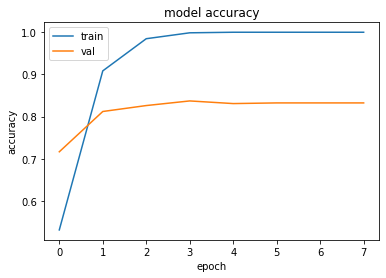

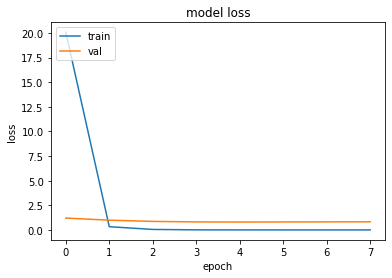

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 131ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.94      0.96      0.95        50
          Edgar_Degas       0.85      0.85      0.85        40
     Vincent_van_Gogh       0.82      0.92      0.86       106
       Albrecht_Dürer       0.80      0.62      0.70        45
        Pablo_Picasso       0.96      0.73      0.83        37
               Titian       0.86      0.75      0.80        67
       Francisco_Goya       0.70      0.73      0.71        48
         Marc_Chagall       0.83      0.69      0.75        51
Pierre-Auguste_Renoir       0.71      0.72      0.72        40
        Alfred_Sisley       0.67      0.79      0.73        39
            Rembrandt       0.84      0.92      0.88       133

             accuracy                           0.82       656
            macro avg       0.82      0.79      0.80       656
         weighted avg       0.82      0.82      0.82       65

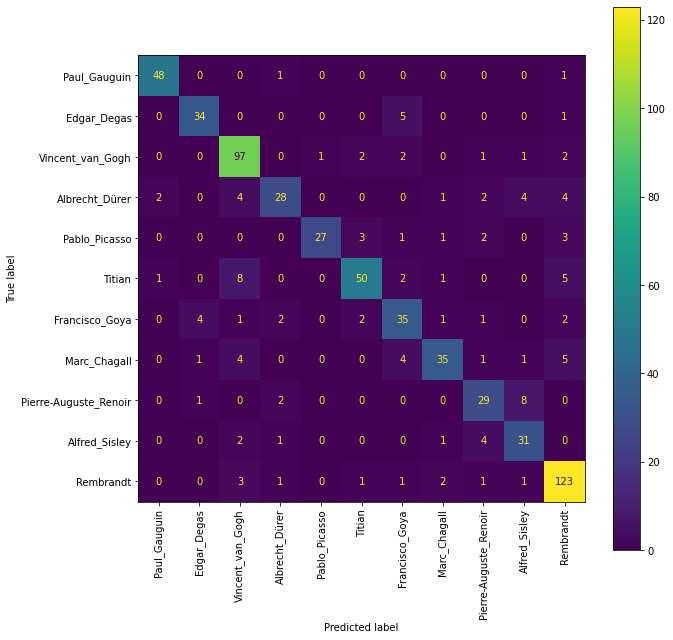

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "ResNet_NoDropout")

## ResNet50 with Dropout

In [ ]:
res_net = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

res_net.trainable = False
res_net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We decided to add a dropout layer after each layer to prevent overfitting

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.resnet.preprocess_input(inputs)
x = res_net(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024,activation='relu', name='classifier_hidden_2')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden_3')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50_Dropout")


model = model_compiler(model)
model.summary()

Model: "ResNet50_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)        

In [ ]:
model, history = model_executor(model, "Dropout_test", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 25.0938 - accuracy: 0.2916
Epoch 1: val_loss improved from inf to 1.36623, saving model to /content/model/Dropout_test.h5
94/94 [==============================] - 612s 6s/step - loss: 25.0938 - accuracy: 0.2916 - val_loss: 1.3662 - val_accuracy: 0.5352
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 3.1284 - accuracy: 0.4883
Epoch 2: val_loss improved from 1.36623 to 1.14260, saving model to /content/model/Dropout_test.h5
94/94 [==============================] - 42s 441ms/step - loss: 3.1284 - accuracy: 0.4883 - val_loss: 1.1426 - val_accuracy: 0.6291
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 2.0310 - accuracy: 0.5832
Epoch 3: val_loss improved from 1.14260 to 1.04494, saving model to /content/model/Dropout_test.h5
94/94 [==============================] - 43s 450ms/step - loss: 2.0310 - accuracy: 0.5832 - val_loss: 1.0449 - val_accuracy: 0.6385
Epoch 4/20
94/94 [===========

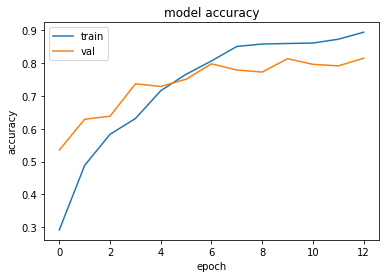

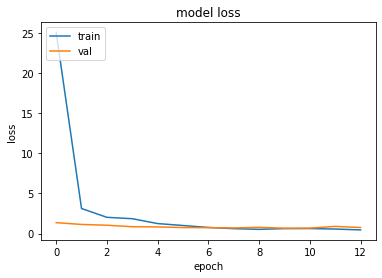

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 104ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.98      0.96      0.97        50
          Edgar_Degas       0.97      0.72      0.83        40
     Vincent_van_Gogh       0.91      0.79      0.85       106
       Albrecht_Dürer       0.72      0.69      0.70        45
        Pablo_Picasso       0.97      0.84      0.90        37
               Titian       0.76      0.75      0.75        67
       Francisco_Goya       0.88      0.60      0.72        48
         Marc_Chagall       0.68      0.75      0.71        51
Pierre-Auguste_Renoir       0.62      0.93      0.74        40
        Alfred_Sisley       0.68      0.59      0.63        39
            Rembrandt       0.76      0.92      0.83       133

             accuracy                           0.80       656
            macro avg       0.81      0.78      0.78       656
         weighted avg       0.81      0.80      0.80       65

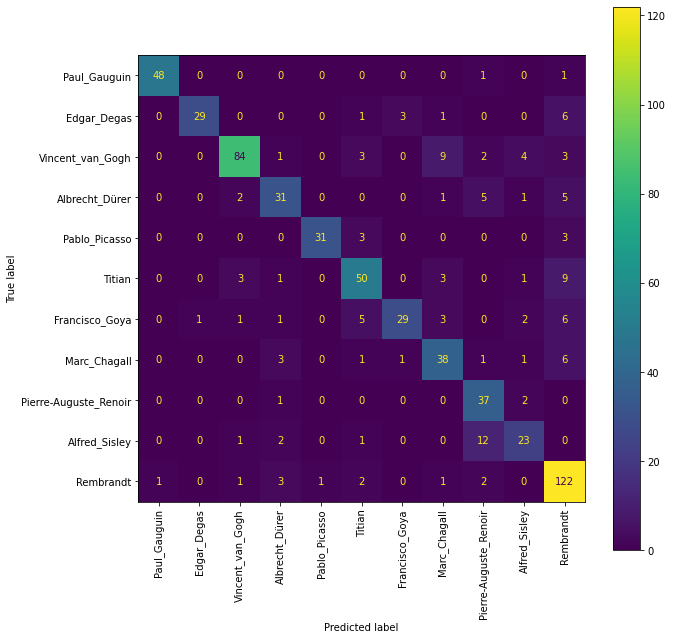

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "ResNet_Dropout")

## ResNet50 Batch Normalization + Dropout

In [ ]:
res_net = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

res_net.trainable = False
res_net.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

We decided to add a dropout layer after each layer to prevent overfitting

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.resnet.preprocess_input(inputs)
x = res_net(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden_1')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization(epsilon = 1e-4)(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden_2')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization(epsilon = 1e-4)(x)

output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50_Batch_Dropout")


model = model_compiler(model, learning_rate=0.00001)
model.summary()

Model: "ResNet50_Batch_Dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 512)   

In [ ]:
model, history = model_executor(model, "ResNet50_Batch_Dropout", training_images, val_images, 100, 7, CLASS_WEIGHTS)

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: 2.9749 - accuracy: 0.2051
Epoch 1: val_loss improved from inf to 1.37737, saving model to /content/model/ResNet50_Batch_Dropout.h5
94/94 [==============================] - 994s 10s/step - loss: 2.9749 - accuracy: 0.2051 - val_loss: 1.3774 - val_accuracy: 0.5759
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 1.8102 - accuracy: 0.4710
Epoch 2: val_loss improved from 1.37737 to 1.08145, saving model to /content/model/ResNet50_Batch_Dropout.h5
94/94 [==============================] - 17s 178ms/step - loss: 1.8102 - accuracy: 0.4710 - val_loss: 1.0814 - val_accuracy: 0.7027
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 1.3462 - accuracy: 0.6029
Epoch 3: val_loss improved from 1.08145 to 0.96871, saving model to /content/model/ResNet50_Batch_Dropout.h5
94/94 [==============================] - 17s 174ms/step - loss: 1.3462 - accuracy: 0.6029 - val_loss: 0.9687 - val_accuracy: 0.72

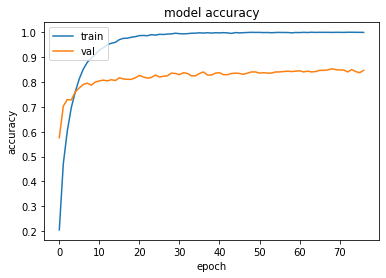

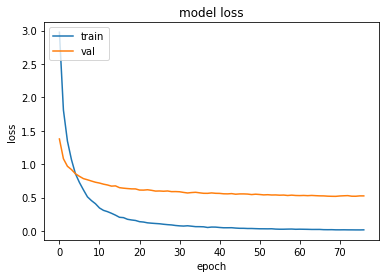

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 4s 95ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.92      0.98      0.95        50
          Edgar_Degas       0.83      0.85      0.84        40
     Vincent_van_Gogh       0.93      0.88      0.90       106
       Albrecht_Dürer       0.81      0.64      0.72        45
        Pablo_Picasso       0.88      0.78      0.83        37
               Titian       0.82      0.81      0.81        67
       Francisco_Goya       0.81      0.73      0.77        48
         Marc_Chagall       0.80      0.69      0.74        51
Pierre-Auguste_Renoir       0.73      0.88      0.80        40
        Alfred_Sisley       0.71      0.77      0.74        39
            Rembrandt       0.84      0.95      0.89       133

             accuracy                           0.84       656
            macro avg       0.83      0.81      0.82       656
         weighted avg       0.84      0.84      0.84       656

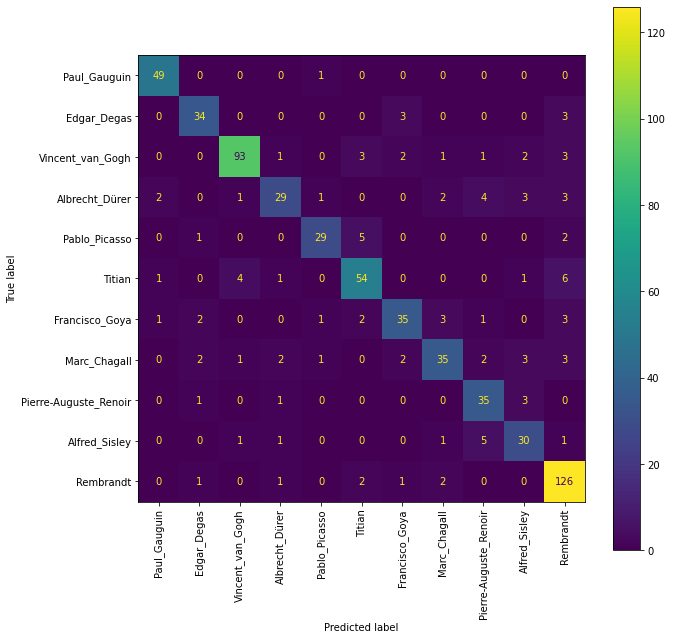

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

In [ ]:
plot_model_structure(model, "ResNet_Batch_Dropout")

## FineTuning

### Unfreezing conv5 block 3_3 (classifier not trainable) learning_rate=0.0001

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/NoDropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if 'conv5_block3_3' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

In [ ]:
model.get_layer("classifier_hidden_1").trainable = False
model.get_layer("classifier_hidden_2").trainable = False
model.get_layer("dense").trainable = False

In [ ]:
model = model_compiler(model, 0.0001)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)             411045888 
                                                          

In [ ]:
model, history = model_executor(model, "FineTuning_block_3_3_class_blocked", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 5.7807e-04 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.87419, saving model to /content/model/FineTuning_block_3_3_class_blocked.h5
94/94 [==============================] - 1052s 10s/step - loss: 5.7807e-04 - accuracy: 1.0000 - val_loss: 0.8742 - val_accuracy: 0.8294
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 2.0299e-04 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.87419
94/94 [==============================] - 14s 143ms/step - loss: 2.0299e-04 - accuracy: 1.0000 - val_loss: 0.8940 - val_accuracy: 0.8326
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 1.1529e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.87419
94/94 [==============================] - 14s 143ms/step - loss: 1.1529e-04 - accuracy: 1.0000 - val_loss: 0.9093 - val_accuracy: 0.8341
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 7.5818e-05 - accura

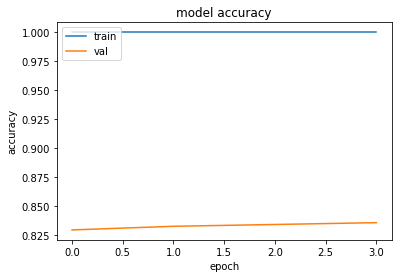

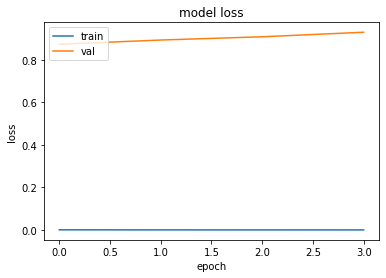

In [ ]:
plot_train_history(history)

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/FineTuning_block_3_3_class_blocked.h5')

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 98ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.94      0.96      0.95        50
          Edgar_Degas       0.83      0.85      0.84        40
     Vincent_van_Gogh       0.80      0.92      0.85       106
       Albrecht_Dürer       0.84      0.58      0.68        45
        Pablo_Picasso       0.97      0.78      0.87        37
               Titian       0.86      0.72      0.78        67
       Francisco_Goya       0.71      0.75      0.73        48
         Marc_Chagall       0.82      0.71      0.76        51
Pierre-Auguste_Renoir       0.71      0.75      0.73        40
        Alfred_Sisley       0.65      0.77      0.71        39
            Rembrandt       0.85      0.90      0.87       133

             accuracy                           0.81       656
            macro avg       0.81      0.79      0.80       656
         weighted avg       0.82      0.81      0.81       656

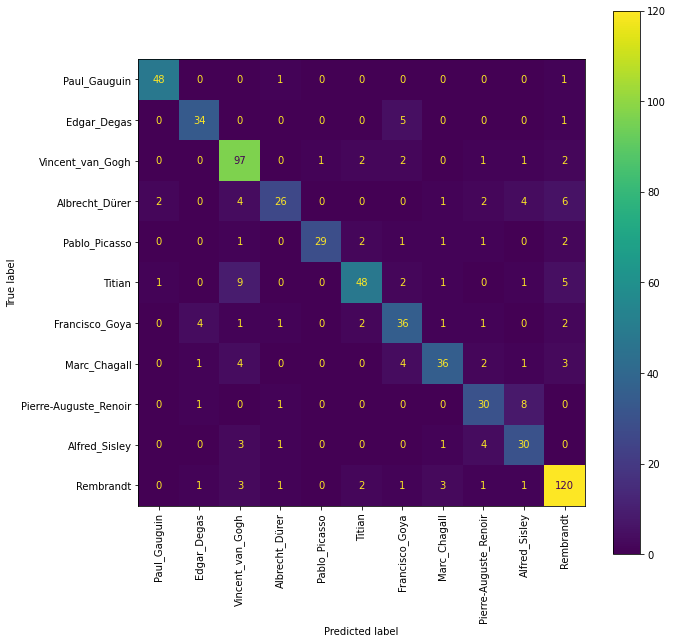

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

### Unfreezing conv5 block 3_3 (classifier not trainable) learning_rate=0.000001

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/NoDropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if 'conv5_block3_3' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

In [ ]:
model.get_layer("classifier_hidden_1").trainable = False
model.get_layer("classifier_hidden_2").trainable = False
model.get_layer("dense").trainable = False

In [ ]:
model = model_compiler(model, 0.000001)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)             411045888 
                                                          

In [ ]:
model, history = model_executor(model, "FineTuning_block_3_3_class_blocked_learning", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 6.4805e-04 - accuracy: 1.0000 
Epoch 1: val_loss improved from inf to 0.80050, saving model to /content/model/FineTuning_block_3_3_class_blocked_learning.h5
94/94 [==============================] - 1463s 14s/step - loss: 6.4805e-04 - accuracy: 1.0000 - val_loss: 0.8005 - val_accuracy: 0.8310
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 6.2709e-04 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.80050
94/94 [==============================] - 16s 162ms/step - loss: 6.2709e-04 - accuracy: 1.0000 - val_loss: 0.8024 - val_accuracy: 0.8310
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 6.0859e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.80050
94/94 [==============================] - 15s 159ms/step - loss: 6.0859e-04 - accuracy: 1.0000 - val_loss: 0.8041 - val_accuracy: 0.8310
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 5.9218e-0

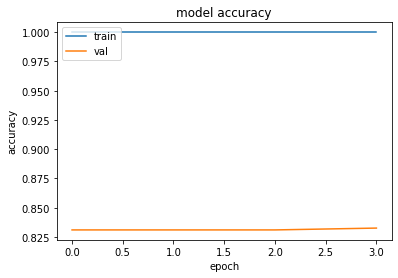

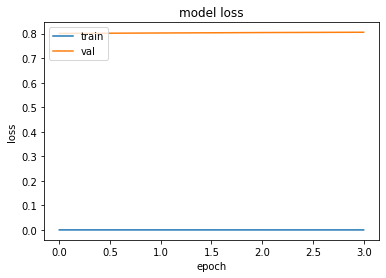

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 115ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.94      0.96      0.95        50
          Edgar_Degas       0.85      0.85      0.85        40
     Vincent_van_Gogh       0.80      0.91      0.85       106
       Albrecht_Dürer       0.82      0.62      0.71        45
        Pablo_Picasso       0.97      0.78      0.87        37
               Titian       0.87      0.72      0.79        67
       Francisco_Goya       0.71      0.75      0.73        48
         Marc_Chagall       0.83      0.69      0.75        51
Pierre-Auguste_Renoir       0.73      0.75      0.74        40
        Alfred_Sisley       0.69      0.79      0.74        39
            Rembrandt       0.84      0.92      0.88       133

             accuracy                           0.82       656
            macro avg       0.82      0.79      0.80       656
         weighted avg       0.82      0.82      0.82       65

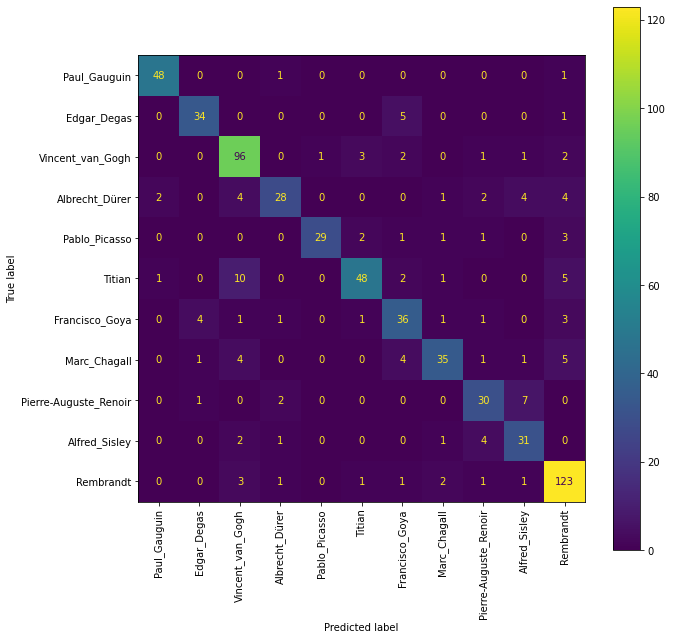

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

### Unfreezing conv5 block 3_3

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/NoDropout.h5', compile=False)

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if 'conv5_block3_3' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

In [ ]:
model = model_compiler(model, 0.0001)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)             411045888 
                                                          

In [ ]:
model, history = model_executor(model, "FineTuning_block_3_3", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9977
Epoch 1: val_loss improved from inf to 1.38034, saving model to /content/model/FineTuning_block_3_3.h5
94/94 [==============================] - 616s 6s/step - loss: 0.0120 - accuracy: 0.9977 - val_loss: 1.3803 - val_accuracy: 0.8279
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9940
Epoch 2: val_loss improved from 1.38034 to 1.01424, saving model to /content/model/FineTuning_block_3_3.h5
94/94 [==============================] - 44s 461ms/step - loss: 0.0269 - accuracy: 0.9940 - val_loss: 1.0142 - val_accuracy: 0.8185
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9997
Epoch 3: val_loss improved from 1.01424 to 0.97589, saving model to /content/model/FineTuning_block_3_3.h5
94/94 [==============================] - 44s 467ms/step - loss: 0.0050 - accuracy: 0.9997 - val_loss: 0.9759 - val_accuracy: 0.8326
Epoch 4

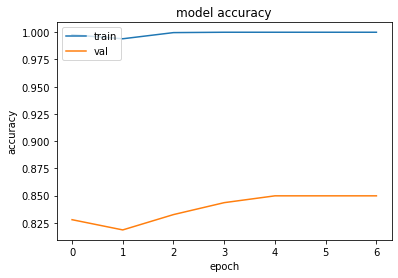

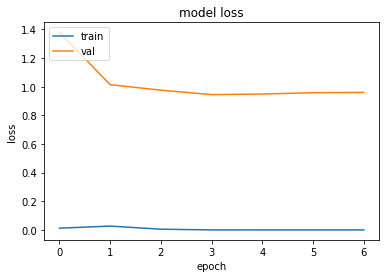

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 110ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.96      0.94      0.95        50
          Edgar_Degas       0.87      0.85      0.86        40
     Vincent_van_Gogh       0.88      0.92      0.90       106
       Albrecht_Dürer       0.91      0.71      0.80        45
        Pablo_Picasso       0.86      0.84      0.85        37
               Titian       0.79      0.81      0.80        67
       Francisco_Goya       0.77      0.71      0.74        48
         Marc_Chagall       0.83      0.75      0.78        51
Pierre-Auguste_Renoir       0.79      0.85      0.82        40
        Alfred_Sisley       0.74      0.82      0.78        39
            Rembrandt       0.85      0.91      0.88       133

             accuracy                           0.84       656
            macro avg       0.84      0.83      0.83       656
         weighted avg       0.85      0.84      0.84       65

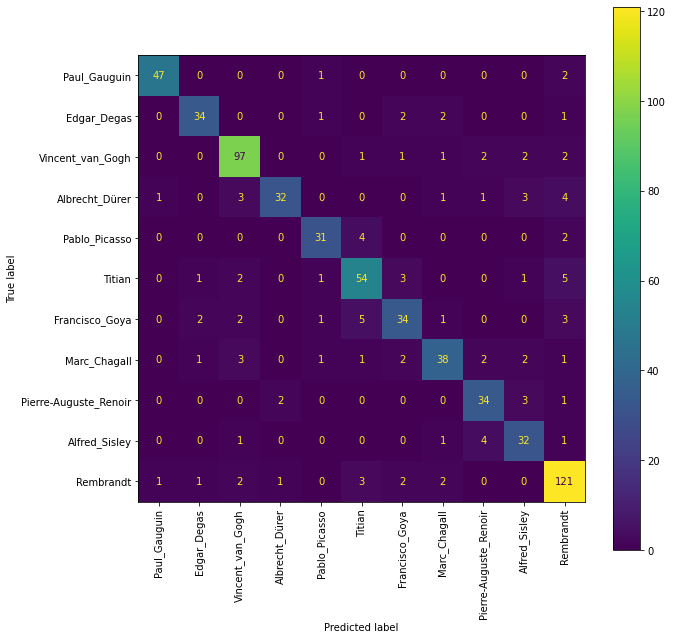

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

### Unfreezing conv 5 block 3

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/NoDropout.h5', compile = False)

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if 'conv5_block3' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

In [ ]:
model = model_compiler(model, 0.0001)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)             411045888 
                                                          

In [ ]:
model, history = model_executor(model, "FineTuning_block_3", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980
Epoch 1: val_loss improved from inf to 0.69544, saving model to /content/model/FineTuning_block_3.h5
94/94 [==============================] - 955s 9s/step - loss: 0.0120 - accuracy: 0.9980 - val_loss: 0.6954 - val_accuracy: 0.8529
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9980
Epoch 2: val_loss did not improve from 0.69544
94/94 [==============================] - 21s 217ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.7005 - val_accuracy: 0.8576
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 5.4958e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.69544
94/94 [==============================] - 21s 218ms/step - loss: 5.4958e-04 - accuracy: 1.0000 - val_loss: 0.7044 - val_accuracy: 0.8623
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 7.4607e-05 - accuracy: 1.0000
Epoch 4: val_loss did n

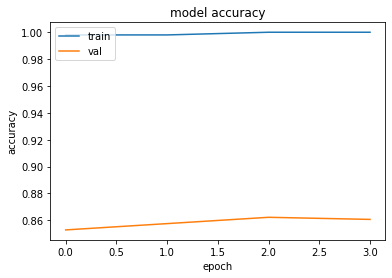

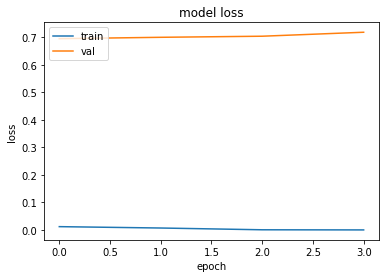

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 106ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.98      0.92      0.95        50
          Edgar_Degas       0.80      0.80      0.80        40
     Vincent_van_Gogh       0.88      0.91      0.89       106
       Albrecht_Dürer       0.83      0.76      0.79        45
        Pablo_Picasso       0.97      0.76      0.85        37
               Titian       0.83      0.79      0.81        67
       Francisco_Goya       0.80      0.75      0.77        48
         Marc_Chagall       0.88      0.73      0.80        51
Pierre-Auguste_Renoir       0.87      0.82      0.85        40
        Alfred_Sisley       0.71      0.92      0.80        39
            Rembrandt       0.83      0.93      0.88       133

             accuracy                           0.85       656
            macro avg       0.85      0.83      0.83       656
         weighted avg       0.85      0.85      0.85       65

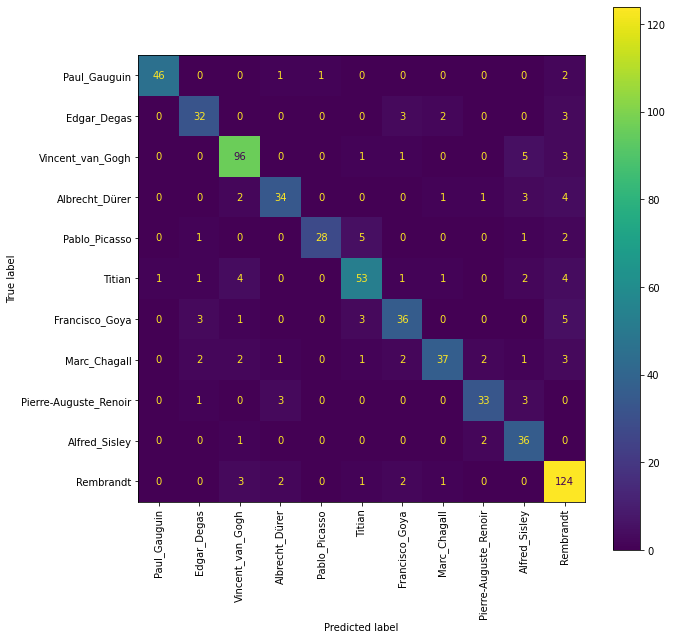

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)

### Unfreezing conv 5

In [ ]:
model = models.load_model('/content/drive/Shareddrives/DeepLearning-ArtClassification/Models/ResNet50Weights/NoDropout.h5', compile = False)

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if 'conv5' in layer.name:
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

In [ ]:
model = model_compiler(model, 0.0001)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 classifier_hidden_1 (Dense)  (None, 4096)             411045888 
                                                          

In [ ]:
model, history = model_executor(model, "FineTuning_conv_5", training_images, val_images, 20, 3, CLASS_WEIGHTS)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9810 
Epoch 1: val_loss improved from inf to 0.56669, saving model to /content/model/FineTuning_conv_5.h5
94/94 [==============================] - 1447s 14s/step - loss: 0.0665 - accuracy: 0.9810 - val_loss: 0.5667 - val_accuracy: 0.8513
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9950
Epoch 2: val_loss did not improve from 0.56669
94/94 [==============================] - 22s 232ms/step - loss: 0.0193 - accuracy: 0.9950 - val_loss: 0.5894 - val_accuracy: 0.8607
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 3: val_loss did not improve from 0.56669
94/94 [==============================] - 22s 233ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.6136 - val_accuracy: 0.8670
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 2.8473e-04 - accuracy: 1.0000
Epoch 4: val_loss did not imp

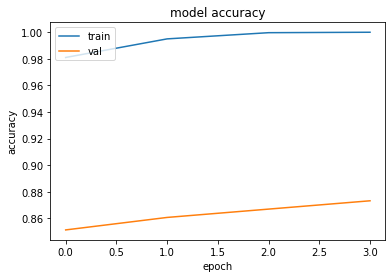

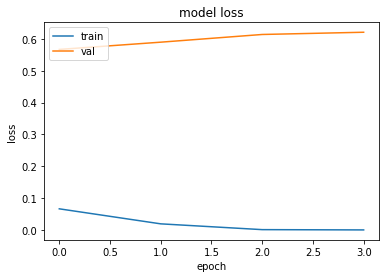

In [ ]:
plot_train_history(history)

In [ ]:
pred_labels = model_evaluator(model, test_images)

21/21 [==============================] - 3s 103ms/step
                       precision    recall  f1-score   support

         Paul_Gauguin       0.92      0.96      0.94        50
          Edgar_Degas       0.86      0.80      0.83        40
     Vincent_van_Gogh       0.91      0.92      0.91       106
       Albrecht_Dürer       0.82      0.82      0.82        45
        Pablo_Picasso       0.97      0.76      0.85        37
               Titian       0.81      0.82      0.81        67
       Francisco_Goya       0.84      0.75      0.79        48
         Marc_Chagall       0.84      0.75      0.79        51
Pierre-Auguste_Renoir       0.85      0.82      0.84        40
        Alfred_Sisley       0.78      0.79      0.78        39
            Rembrandt       0.83      0.94      0.88       133

             accuracy                           0.85       656
            macro avg       0.86      0.83      0.84       656
         weighted avg       0.86      0.85      0.85       65

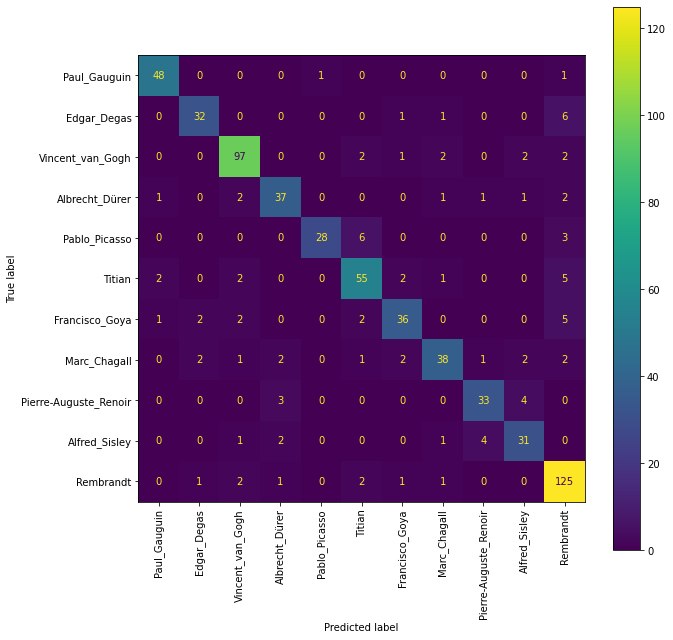

In [ ]:
confusion_matrix_maker(model, test_images, pred_labels)